##Importaciones

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

##Cargar Dataset

In [13]:
# Datos simulados para una semana (7 días) con 48 pings diarios (cada 30 minutos)
users = [1, 2, 3]  # 3 usuarios
days = list(range(7))  # 7 días (una semana)
hours = list(range(48))  # 48 "horas" para representar los pings

# Crear un dataset simulado
data = []
for user in users:
    for day in days:
        for hour in hours:
            x = np.random.randint(0, 200)  # Coordenada X aleatoria
            y = np.random.randint(0, 200)  # Coordenada Y aleatoria
            data.append([user, day, hour, x, y])

# Crear DataFrame
df = pd.DataFrame(data, columns=['user', 'day', 'hour', 'x', 'y'])
print("Dataset creado:")
print(df.head())

Dataset creado:
   user  day  hour    x    y
0     1    0     0  105   45
1     1    0     1  166   28
2     1    0     2  159  188
3     1    0     3  130   67
4     1    0     4  117  120


##Preprocesamiento y Creación de Secuencias

In [14]:
# Preprocesamiento
scaler = MinMaxScaler()
numerical_cols = ['day', 'hour', 'x', 'y']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Creación de secuencias
def create_sequences(data, seq_length):
    X, y = [], []
    if len(data) < seq_length + 1:  # Validación
        raise ValueError(f"Insufficient data: need at least {seq_length+1} rows, but got {len(data)}")

    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_length = 7  # Ventana de una semana
X, y = create_sequences(df[numerical_cols].values, seq_length)

# Dataset y DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TimeSeriesDataset(X, y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

##Modelos


In [15]:
# Modelo Simple NN
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplanar
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

# Modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# Modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hn = self.gru(x)
        return self.fc(hn[-1])

# Modelo RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hn = self.rnn(x)
        return self.fc(hn[-1])


##Función de Entrenamiento

In [16]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []  # Almacena las pérdidas
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_loss = total_loss / len(dataloader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
    return losses  # Asegúrate de retornar las pérdidas


##Entrenamiento y Gráficas Comparativas

Entrenando SimpleNN...
Epoch [1/10], Loss: 0.0771
Epoch [2/10], Loss: 0.0542
Epoch [3/10], Loss: 0.0522
Epoch [4/10], Loss: 0.0510
Epoch [5/10], Loss: 0.0496
Epoch [6/10], Loss: 0.0499
Epoch [7/10], Loss: 0.0490
Epoch [8/10], Loss: 0.0489
Epoch [9/10], Loss: 0.0484
Epoch [10/10], Loss: 0.0480
Entrenando LSTM...
Epoch [1/10], Loss: 0.0862
Epoch [2/10], Loss: 0.0577
Epoch [3/10], Loss: 0.0545
Epoch [4/10], Loss: 0.0536
Epoch [5/10], Loss: 0.0513
Epoch [6/10], Loss: 0.0499
Epoch [7/10], Loss: 0.0507
Epoch [8/10], Loss: 0.0490
Epoch [9/10], Loss: 0.0491
Epoch [10/10], Loss: 0.0488
Entrenando GRU...
Epoch [1/10], Loss: 0.0705
Epoch [2/10], Loss: 0.0532
Epoch [3/10], Loss: 0.0510
Epoch [4/10], Loss: 0.0501
Epoch [5/10], Loss: 0.0495
Epoch [6/10], Loss: 0.0496
Epoch [7/10], Loss: 0.0494
Epoch [8/10], Loss: 0.0491
Epoch [9/10], Loss: 0.0487
Epoch [10/10], Loss: 0.0488
Entrenando RNN...
Epoch [1/10], Loss: 0.0632
Epoch [2/10], Loss: 0.0524
Epoch [3/10], Loss: 0.0510
Epoch [4/10], Loss: 0.0501
E

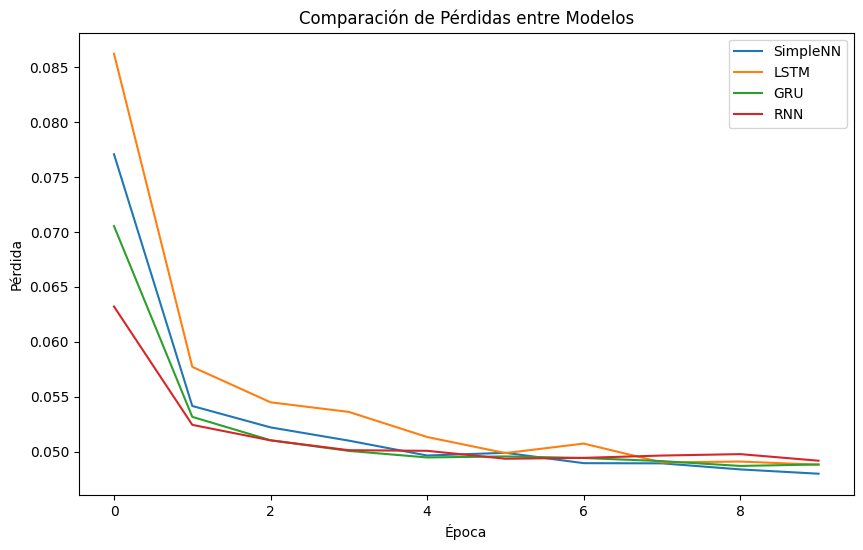

In [17]:
input_size = len(numerical_cols)
hidden_size = 64
num_layers = 2
output_size = len(numerical_cols)

# Inicializar modelos
simple_nn = SimpleNN(input_size * seq_length, hidden_size, output_size)
lstm = LSTMModel(input_size, hidden_size, num_layers, output_size)
gru = GRUModel(input_size, hidden_size, num_layers, output_size)
rnn = RNNModel(input_size, hidden_size, num_layers, output_size)

# Entrenar modelos
print("Entrenando SimpleNN...")
loss_simple_nn = train_model(simple_nn, dataloader)

print("Entrenando LSTM...")
loss_lstm = train_model(lstm, dataloader)

print("Entrenando GRU...")
loss_gru = train_model(gru, dataloader)

print("Entrenando RNN...")
loss_rnn = train_model(rnn, dataloader)

# Graficar pérdidas
plt.figure(figsize=(10, 6))
plt.plot(loss_simple_nn, label="SimpleNN")
plt.plot(loss_lstm, label="LSTM")
plt.plot(loss_gru, label="GRU")
plt.plot(loss_rnn, label="RNN")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Comparación de Pérdidas entre Modelos")
plt.legend()
plt.show()
